In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [85]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [86]:
# run this ceil for different data sets

α = [1.0, 0.5] # single index for x
θ = [0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 0.5] # single index for z
β = [0.5, 1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 500
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 0
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

width in alpha :[0.5053195481928565, 0.5053195481928565]
width in alpha :[0.47637916160477184, 0.47637916160477184]
width in alpha :[0.416155529385385, 0.416155529385385]
width in alpha :[0.39181354787806394, 0.39181354787806394]
width in alpha :[0.5080659040187326, 0.5080659040187326]
width in alpha :[0.513743087932273, 0.513743087932273]
first v: -3.351831521006287 2.112615375286433
final c: -0.2935176311296038 0.10737685762863401
final v: -3.351831521006287 2.112615375286433
6
  5.712081 seconds (8.87 M allocations: 12.796 GiB, 5.35% gc time, 51.01% compilation time)
Estimation of index coefs: 
̂α => [0.6146570170966387; 0.7887944924591338]
̂γ => [0.3491609505190303, 0.4596830237224423]
Estimation of linear coefs: 
̂θ => [0.9058786767160061 -0.7058932213710375]
̂β => [0.5543269980674949, 0.9573396307386293]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

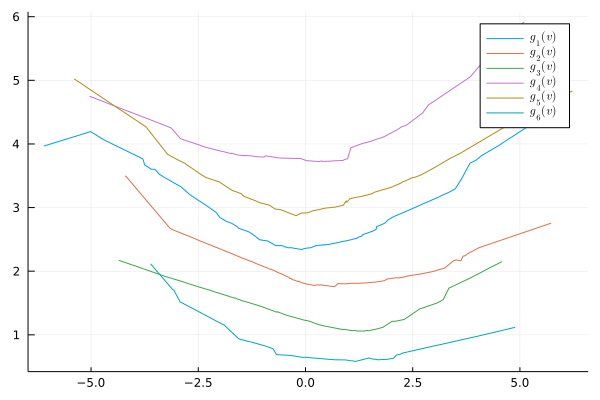

In [83]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * transpose(theta), 0.5, -0.4) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

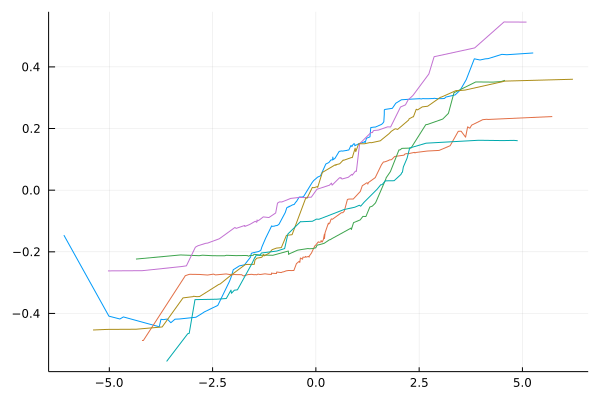

In [84]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = false )#L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [40]:
Threads.nthreads()

4

In [72]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [73]:
α = [1.0, 0.5] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 400
fx = 2
dist = 1 # Cauchy
rep = 20 # MC rept. times

20

In [74]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, fx, dist, rep)
mean(Gamma, dims = 1)

first v: -2.853966896437017 2.8219752554942303
final c: 0.7688213009904048 1.0237331832238654
final v: -2.853966896437017 2.8219752554942303
6
first v: -2.15744401013865 2.968542557730446
final c: -0.8153824237720695 -0.8146785000841448
final v: -2.15744401013865 2.968542557730446
6
first v: -2.408519326038676 2.7897966072168066
final c: -0.379832303905321 -0.3042760788401417
final v: -2.408519326038676 2.7897966072168066
6
first v: -2.28190203311945 2.2117562983253842
final c: -0.8381908763198939 -0.7565012662770069
final v: -3.0979831355917176 3.027837400797652
6
first v: -2.903204719017511 3.271502151570145
final c: -1.155026113037499 -1.0888911873605764
final v: -2.903204719017511 3.271502151570145
6
first v: -2.1436025109008128 2.5683871698616
first v: -2.1436025109008128 2.5683871698616
final c: -0.6775704182501732 -0.4767691228974726
final v: -2.1436025109008128 2.5683871698616
5
first v: -3.546686281121792 1.3978965798244956
final c: 0.4812774462301384 0.9391811664260302
final 

1×2 Matrix{Float64}:
 0.543332  0.816672

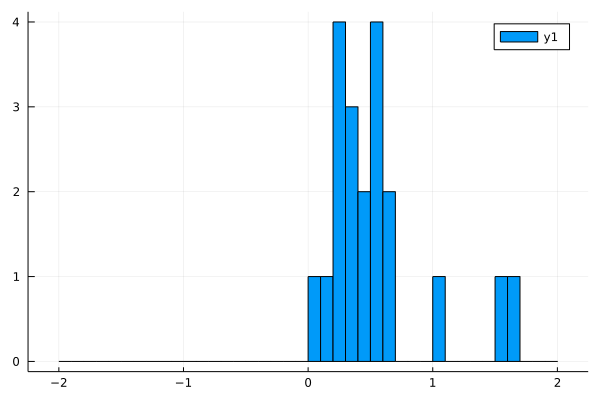

In [75]:
histogram(Gamma[:,1], bins = -2:0.1:2)

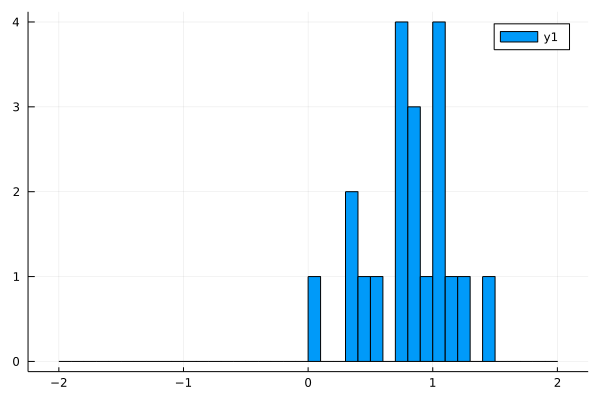

In [76]:
histogram(Gamma[:,2], bins = -2:0.1:2)

In [77]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.729202  0.579895

In [78]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 1.11643  -0.0835995

In [79]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.25649  -1.5878

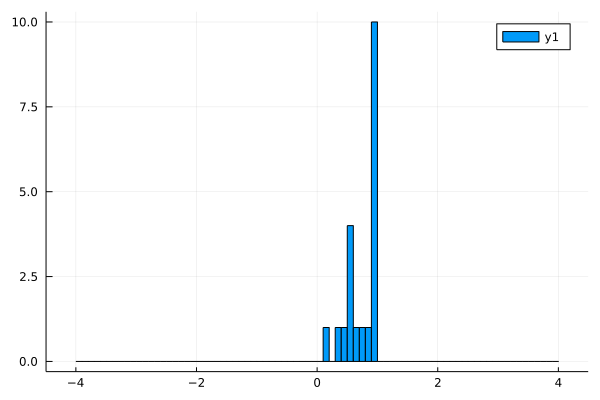

In [80]:
histogram(Alpha[:,1], bins = -4:0.1:4)

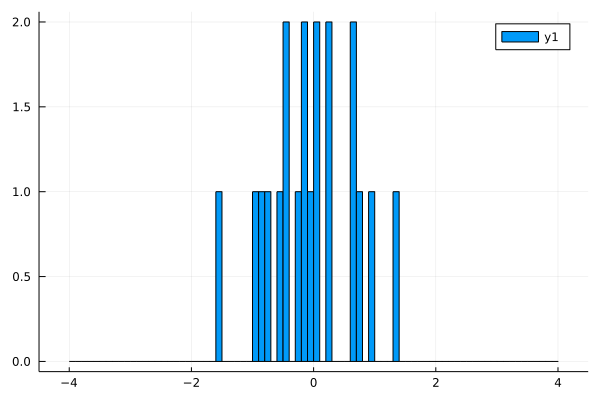

In [65]:
histogram(Beta[:,2], bins = -4:0.1:4)